In [1]:
# QUESTION 4
# Can a predictive model be built for future prediction of the possibility of complaints of the specific type 
# that you identified in response to Question 1 (HEAT/HOT WATER(HHW))?

# CONTEXT:

# The first thing to do is to define the meaning of "predictive model for future prediction of the possibility of HHW
# complaints". In this sense, the "possibility of complaints by HHW" can be interpreted as the probability that future
# complaints correspond to the HHW type, this could be expressed as:

# “Number of complaints HHW / Total complaints NYC311”

# However, another way to interpret this can be analyzing, according to the characteristics of NYC houses, how similar 
# are they to those that have already registered complaints by HHW, and on this basis estimate how prone they are, or how
# likely is each house to register this type of complaint.

# In order to provide the best advice to DHPDNYC, this notebook addresses both approaches in the following way:

#    a. Time series approach:
#       The proportion of HHW complaints will be calculated in relation to the total number of complaints registered in
#       the NYC311 for each year and for each month up to 12/31/2018 and that proportion will be estimated for 2019.
#       In the same way, it will be calculated the proportion of houses with HHW complaints in relation to the total 
#       number of NYC houses

#       Notice that time series analysis use to be done with techniques like ARIMA (Auto Regressive Integrated Moving 
#       Average) or SARIMA (Seasonal Auto Regressive Integrated Moving Average) models, however it is out of the scope
#       of this notebook.

#    b. Multivariate classification approach:
#       Through the classification methods (KNN, Log Regression, SVM) and the characteristics of the houses available in
#       the PLUTO data, models will be defined that identify the NYC houses are likely to register complaints of the HHW
#       type, and will be verified which model registers greater precision.

#       For this classification, the data of the houses will be splitted into 2 groups:

#          b.1. True: Houses that registered HHW complaints only in 2018
#          b.2. False: Homes that did not register HHW complaints in 2018

#       Notice that the houses that registered HHW complaints but not in 2018 are also classified in the "False" group. 
#       This is because any house with problems of HHW from previous years that have not been solved yet, will also have
#       registered complaints in 2018, then it is considered sufficient to include in the "True" group only the houses 
#       that registered complaints in 2018.

# Note:
# In accordance with the previous questions, only complaints of dates less than or equal to 2018/12/31 will be considered to answer this question


In [2]:
# 0. PREPROCESSING:

# 0.1. Importing basic libraries:

import pandas as pd
import numpy as np 
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime
mpl.style.use("ggplot")
%matplotlib inline

In [3]:
# 0.2. Downloading complains dataset:

import types
from botocore.client import Config
import ibm_boto3

client_cred = ibm_boto3.client(service_name='s3',
ibm_api_key_id=<**REPLACE_WITH_YOUR_IBM_API_KEY_ID**>,
ibm_auth_endpoint='https://iam.bluemix.net/oidc/token',
config=Config(signature_version='oauth'),
endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

bucket = <**REPLACE_WITH_BUCKET_ID_**>

client_cred.download_file(Bucket=bucket,Key='df_raw_cos.pkl',Filename='./df_raw_local.pkl')

DF = pd.read_pickle('./df_raw_local.pkl')


In [4]:
client_cred.download_file(Bucket=bucket,Key='df_raw2_cos.pkl',Filename='./df_raw2_local.pkl')

DF_PLUTO = pd.read_pickle('./df_raw2_local.pkl')

In [5]:
# 0.2.1. Preprocessing complaints data:

DF["complaint_type"]=np.where(DF["complaint_type"]=="HEATING","HEAT/HOT WATER",DF["complaint_type"])
DF01=DF[DF["created_date"]<='2018-12-31']
df_compl02=DF01.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df_compl02= df_compl02.sort_values(by="created_date",ascending=True)
df_compl02.reset_index(drop=True,inplace=True)
df_compl02.shape #describe(include="all")

# 0.2.2. Identifying HHW and 2018 HHW complaints:

df_compl02["hhw"]=(df_compl02["complaint_type"]=="HEAT/HOT WATER")

df_compl02["hhw2018"]=(df_compl02["complaint_type"]=="HEAT/HOT WATER")&(df_compl02["created_date"]>="2018-01-01")

df_compl02.shape #["hhw2018"].value_counts() #shape #head() #dtypes


(5321676, 16)

In [6]:
df_compl02.head() #["hhw2018"].value_counts() #shape #head() #dtypes


,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status,hhw,hhw2018
0,2010-01-01,15635212,PLUMBING,10457.0,1814 WEEKS AVENUE,WEEKS AVENUE,ADDRESS,BRONX,Unspecified,40.847129,-73.907337,2010-01-27,RESIDENTIAL BUILDING,Closed,False,False
1,2010-01-01,15634822,HEAT/HOT WATER,11214.0,8750 BAY PARKWAY,BAY PARKWAY,ADDRESS,BROOKLYN,Unspecified,40.599068,-73.996817,2010-01-10,RESIDENTIAL BUILDING,Closed,True,False
2,2010-01-01,15634823,HEAT/HOT WATER,10451.0,635 MORRIS AVENUE,MORRIS AVENUE,ADDRESS,BRONX,Unspecified,40.819177,-73.921954,2010-01-06,RESIDENTIAL BUILDING,Closed,True,False
3,2010-01-01,15634824,HEAT/HOT WATER,11694.0,182 BEACH 113 STREET,BEACH 113 STREET,ADDRESS,ROCKAWAY PARK,Unspecified,40.580059,-73.834279,2010-01-05,RESIDENTIAL BUILDING,Closed,True,False
4,2010-01-01,15634825,HEAT/HOT WATER,11213.0,1009 LINCOLN PLACE,LINCOLN PLACE,ADDRESS,BROOKLYN,Unspecified,40.670413,-73.943180,2010-01-04,RESIDENTIAL BUILDING,Closed,True,False


In [7]:
# 0.4. Totalizing number of 2018s "HEAT/HOT WATER" complaints per each address:

# df per house (including the number of 2018 HHW complaints of each house and a boolean for those cases) 
z01=df_compl02.groupby(["incident_address"],as_index=False).sum()
z02=z01[["incident_address","hhw2018","hhw"]]
z02["hhw2018bool"]=z02["hhw2018"]>0
z02["hhwbool"]=z02["hhw"]>0
z02.head() #shape #shape #dtypes #head(20)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,incident_address,hhw2018,hhw,hhw2018bool,hhwbool
0,.537 SHEPERD AVE,0.0,0.0,False,False
1,1 1 AVENUE,0.0,1.0,False,True
2,1 1 PLACE,0.0,0.0,False,False
3,1 12 STREET,0.0,1.0,False,True
4,1 43 STREET,0.0,1.0,False,True


In [8]:
# 0.5. Merging PLUTOs Data set with total number of 2018s "HEAT/HOT WATER" complaints per each address 

DF01=pd.merge(DF_PLUTO,z02,left_on="Address",right_on="incident_address",how="left")
DF01.reset_index(drop=True,inplace=True)
DF01.fillna(0, inplace=True)   #DF01.replace("NaN","0")
DF01["hhwbool"]=DF01["hhwbool"].astype(bool) #DF01.hhwbool.replace(0,False)
DF01["hhw2018bool"]=DF01["hhw2018bool"].astype(bool) #DF01.hhwbool.replace(0,False)
DF01["hhwbool"].value_counts() #head() #dtypes #head() #shape


False    712327
True     101424
Name: hhwbool, dtype: int64

In [9]:
# 1. TIME SERIES APPROACH TO FORECAST THE PROPORTION OF HHW COMPLAINTS:

# The proportion of HHW complaints will be calculated in relation to the total number of complaints registered in the 
# NYC311 for each quarter up to 2018/12/31 and that proportion will be estimated for 2019Q1. In the same 
# way, it will be calculated the proportion of houses with HHW complaints in relation to the total number of NYC houses with complaints

# 1.1. Rate of HHW complaints per quarter:
# 1.1.1. Computing Rate of HHW complaints per quarter:

ts_comp_q_01=df_compl02[["complaint_type"]].groupby([df_compl02["created_date"].dt.year.rename("year"),
                                                     df_compl02["created_date"].dt.quarter.rename("quarter")]).count()
ts_comp_q_02=df_compl02[["hhw"]].groupby([df_compl02["created_date"].dt.year.rename("year"),
                                                     df_compl02["created_date"].dt.quarter.rename("quarter")]).sum()
ts_comp_q_00=pd.merge(ts_comp_q_02,ts_comp_q_01,left_on=["year","quarter"],right_on=["year","quarter"],how="inner")
ts_comp_q_00["part%"]=100*(ts_comp_q_00["hhw"]/ts_comp_q_00["complaint_type"])
ts_comp_q_00.columns=["hhw_tot","compl_tot","part%"]

ts_comp_q_00.index=map(str,ts_comp_q_00.index)
ts_comp_q_00.reset_index(inplace=True)
ts_comp_q_00.columns=["index2","hhw_tot","compl_tot","part%"]

ts_comp_q_00["year"] = ts_comp_q_00["index2"].str[-8:-4].astype(np.int)
ts_comp_q_00["quarter"] = ts_comp_q_00["index2"].str[-2:-1].astype(np.int)
ts_comp_q_00.head(2)

,index2,hhw_tot,compl_tot,part%,year,quarter
0,"(2010, 1)",82274.0,203724,40.385031,2010,1
1,"(2010, 2)",17586.0,120249,14.624654,2010,2


In [10]:
# 1.1.1.1. Exploratory Analysis:

ts_comp_q_00[["hhw_tot","compl_tot","part%"]].describe(include="all")

# Notice that "quarterly hhw complaints rate" has a mean of 30.5%, with a standard of 18.6%. Since a very very general 
# perspective, it can be understood as, the probability to new complaints correspond to "hhw" is in average 0.336. 
# However, it is possible to go deeper in this analysis, so next, I´m going to check if there is any trend and modeling it.


,hhw_tot,compl_tot,part%
count,36.000000,36.000000,36.000000
mean,52159.583333,147824.333333,30.483405
std,40562.457871,45374.209587,18.561257
min,5804.000000,65337.000000,4.460905
25%,14549.250000,104187.500000,12.950321
50%,48952.000000,143992.500000,32.166850
75%,84502.250000,184621.750000,47.920474
max,121490.000000,225102.000000,55.125256


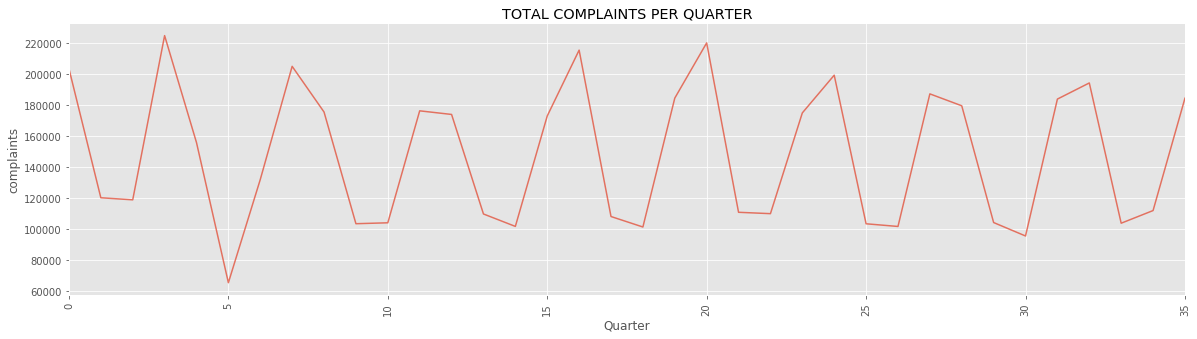

Total complaints per quarter suggests seasonal behavior


In [11]:
# 1.1.1.2. Visualizating total complaints per quarter:

ts_comp_q_00["compl_tot"].plot(kind='line',alpha=0.75, rot=90, figsize=(20, 5))
plt.ylabel('complaints') # , size=20)
plt.xlabel('Quarter') # , size=20)
plt.title("TOTAL COMPLAINTS PER QUARTER") # , size=10)
plt.show()

print("Total complaints per quarter suggests seasonal behavior")


In [12]:
# 1.1.1.3. Seasonally adjusted series through quarterly analysis
# Total Complaint frames


ts_comp_q1b=ts_comp_q_00[ts_comp_q_00["quarter"]==1]
ts_comp_q1b.reset_index(inplace=True,drop=True)
ts_comp_q1=ts_comp_q1b[["year","compl_tot"]]
ts_comp_q1.set_index("year",inplace=True)

ts_comp_q2b=ts_comp_q_00[ts_comp_q_00["quarter"]==2]
ts_comp_q2b.reset_index(inplace=True,drop=True)
ts_comp_q2=ts_comp_q2b[["year","compl_tot"]]
ts_comp_q2.set_index("year",inplace=True)

ts_comp_q3b=ts_comp_q_00[ts_comp_q_00["quarter"]==3]
ts_comp_q3b.reset_index(inplace=True,drop=True)
ts_comp_q3=ts_comp_q3b[["year","compl_tot"]]
ts_comp_q3.set_index("year",inplace=True)

ts_comp_q4b=ts_comp_q_00[ts_comp_q_00["quarter"]==4]
ts_comp_q4b.reset_index(inplace=True,drop=True)
ts_comp_q4=ts_comp_q4b[["year","compl_tot"]]
ts_comp_q4.set_index("year",inplace=True)

ts_comp_q4.shape

(9, 1)

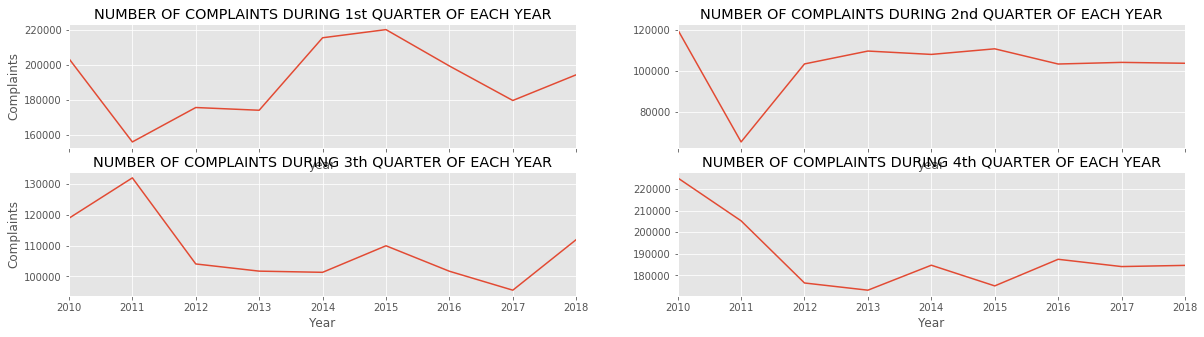

In [13]:
# Total Complaint Visualization

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
ts_comp_q1["compl_tot"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("NUMBER OF COMPLAINTS DURING 1st QUARTER OF EACH YEAR")
# ax0.set_xlabel("Year")
ax0.set_ylabel("Complaints")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
ts_comp_q2["compl_tot"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("NUMBER OF COMPLAINTS DURING 2nd QUARTER OF EACH YEAR")
# ax1.set_xlabel("Year")
# ax1.set_ylabel("Complaints")
ax1.set_xticklabels(())

# Subplot 1: Quarter III
ts_comp_q3["compl_tot"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("NUMBER OF COMPLAINTS DURING 3th QUARTER OF EACH YEAR")
ax2.set_xlabel("Year")
ax2.set_ylabel("Complaints")

# Subplot 2: Quarter IV
ts_comp_q4["compl_tot"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("NUMBER OF COMPLAINTS DURING 4th QUARTER OF EACH YEAR")
ax3.set_xlabel("Year")
# ax3.set_ylabel("Complaints")

plt.show()

# Total complaints separated by quarters show more homogeneous behaviors, and consequently more predictable ones. Additionally, an atypical
# behavior can be seen in 2010 and 2011 (regardless of the quarter assessed). Probably because these are the first years of the NYC311 service.
# Consequently, those years will not be considered for the 2019 predictions.

In [14]:
# 1.1.1.4. Modeling total complaints per quarter:
# 1.1.1.4.1. Preprocessing

DF_Q1c=ts_comp_q1b[["year","compl_tot"]]
DF_Q1c=DF_Q1c[DF_Q1c["year"]>2011]

DF_Q2c=ts_comp_q2b[["year","compl_tot"]]
DF_Q2c=DF_Q2c[DF_Q2c["year"]>2011]

DF_Q3c=ts_comp_q3b[["year","compl_tot"]]
DF_Q3c=DF_Q3c[DF_Q3c["year"]>2011]

DF_Q4c=ts_comp_q4b[["year","compl_tot"]]
DF_Q4c=DF_Q4c[DF_Q4c["year"]>2011]


DF_Q1c.columns=["year","complaints"]
DF_Q2c.columns=["year","complaints"]
DF_Q3c.columns=["year","complaints"]
DF_Q4c.columns=["year","complaints"]

msk=np.random.rand(7)<.5714

train1c=DF_Q1c[msk]
train2c=DF_Q2c[msk]
train3c=DF_Q3c[msk]
train4c=DF_Q4c[msk]

test1c=DF_Q1c[~msk]
test2c=DF_Q2c[~msk]
test3c=DF_Q3c[~msk]
test4c=DF_Q4c[~msk]

In [15]:
# 1.1.1.4.2. Lineal complaints modeling:

from sklearn import linear_model
regr1c=linear_model.LinearRegression()
regr2c=linear_model.LinearRegression()
regr3c=linear_model.LinearRegression()
regr4c=linear_model.LinearRegression()

# Quarter I:
X1c=np.asanyarray(train1c[["year"]])
y1c=np.asanyarray(train1c[["complaints"]])
regr1c.fit(X1c,y1c)
yhat1c=regr1c.predict(test1c[["year"]])
X_test1c=np.asanyarray(test1c[["year"]])
y_test1c=np.asanyarray(test1c[["complaints"]])

# Quarter II:
X2c=np.asanyarray(train2c[["year"]])
y2c=np.asanyarray(train2c[["complaints"]])
regr2c.fit(X2c,y2c)
yhat2c=regr2c.predict(test2c[["year"]])
X_test2c=np.asanyarray(test2c[["year"]])
y_test2c=np.asanyarray(test2c[["complaints"]])

# Quarter III:
X3c=np.asanyarray(train3c[["year"]])
y3c=np.asanyarray(train3c[["complaints"]])
regr3c.fit(X3c,y3c)
yhat3c=regr3c.predict(test3c[["year"]])
X_test3c=np.asanyarray(test3c[["year"]])
y_test3c=np.asanyarray(test3c[["complaints"]])

# Quarter IV:
X4c=np.asanyarray(train4c[["year"]])
y4c=np.asanyarray(train4c[["complaints"]])
regr4c.fit(X4c,y4c)
yhat4c=regr4c.predict(test4c[["year"]])
X_test4c=np.asanyarray(test4c[["year"]])
y_test4c=np.asanyarray(test4c[["complaints"]])

In [16]:
# 1.1.1.4.3. Predicting:

d_2019={"year":np.linspace(2012,2019,8)}
df2019=pd.DataFrame(d_2019)
x2019=np.asanyarray(df2019)

yhat20191c=pd.DataFrame(regr1c.predict(x2019))
yhat20192c=pd.DataFrame(regr2c.predict(x2019))
yhat20193c=pd.DataFrame(regr3c.predict(x2019))
yhat20194c=pd.DataFrame(regr4c.predict(x2019))

hist1c=ts_comp_q1b[ts_comp_q1b["year"]>2011]
hist1c.reset_index(inplace=True,drop=True)

hist2c=ts_comp_q2b[ts_comp_q2b["year"]>2011]
hist2c.reset_index(inplace=True,drop=True)

hist3c=ts_comp_q3b[ts_comp_q3b["year"]>2011]
hist3c.reset_index(inplace=True,drop=True)

hist4c=ts_comp_q4b[ts_comp_q4b["year"]>2011]
hist4c.reset_index(inplace=True,drop=True)

pred2019c = pd.concat([df2019,hist1c["compl_tot"],hist2c["compl_tot"],hist3c["compl_tot"],hist4c["compl_tot"],
                       yhat20191c, yhat20192c, yhat20193c, yhat20194c], axis=1)
column=["year","Q1","Q2","Q3","Q4","estQ1","estQ2","estQ3","estQ4"]
pred2019c.columns=column
pred2019c.set_index("year",inplace=True)
pred2019c.shape #round()

(8, 8)

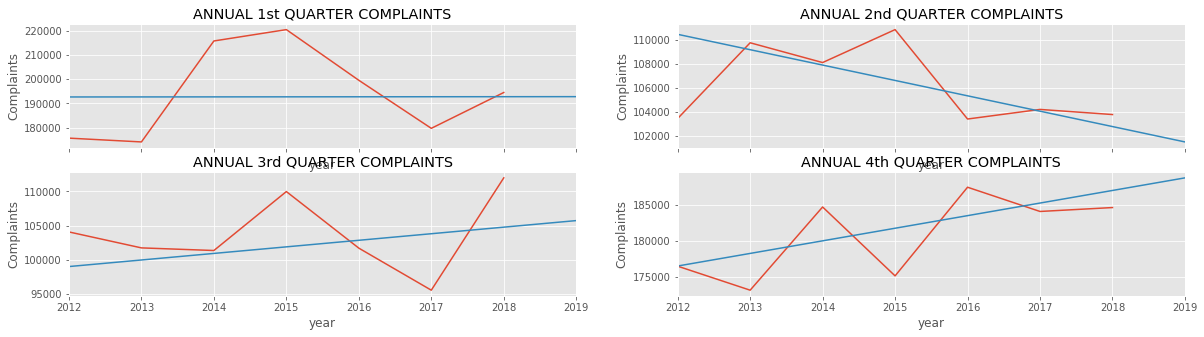

In [17]:
# 1.1.1.4.4. Plotting:

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
pred2019c["Q1"].plot(kind="line",figsize=(20,5),ax=ax0)
pred2019c["estQ1"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("ANNUAL 1st QUARTER COMPLAINTS")
# ax0.set_xlabel("Year")
ax0.set_ylabel("Complaints")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
pred2019c["Q2"].plot(kind="line",figsize=(20,5),ax=ax1)
pred2019c["estQ2"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("ANNUAL 2nd QUARTER COMPLAINTS")
# ax0.set_xlabel("Year")
ax1.set_ylabel("Complaints")
ax1.set_xticklabels(())

# Subplot 3: Quarter III
pred2019c["Q3"].plot(kind="line",figsize=(20,5),ax=ax2)
pred2019c["estQ3"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("ANNUAL 3rd QUARTER COMPLAINTS")
# ax0.set_xlabel("Year")
ax2.set_ylabel("Complaints")
# ax2.set_xticklabels(())

# Subplot 4: Quarter IV
pred2019c["Q4"].plot(kind="line",figsize=(20,5),ax=ax3)
pred2019c["estQ4"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("ANNUAL 4th QUARTER COMPLAINTS")
# ax0.set_xlabel("Year")
ax3.set_ylabel("Complaints")
# ax3.set_xticklabels(())

plt.show()

In [18]:
# 1.1.1.4.5. Metrics:

from sklearn.metrics import r2_score

coeff=[regr1c.coef_[0][0],regr2c.coef_[0][0],regr3c.coef_[0][0],regr4c.coef_[0][0]]
intercept=[regr1c.intercept_[0],regr2c.intercept_[0],regr3c.intercept_[0],regr4c.intercept_[0]]
ResSumSqr=[np.mean((yhat1c-y_test1c)**2),np.mean((yhat2c-y_test2c)**2),np.mean((yhat3c-y_test3c)**2),np.mean((yhat4c-y_test4c)**2)]
VarScore=[regr1c.score(X_test1c,y_test1c),regr2c.score(X_test2c,y_test2c),regr3c.score(X_test3c,y_test3c),regr4c.score(X_test4c,y_test4c)]
R2Score=[r2_score(yhat1c,y_test1c),r2_score(yhat2c,y_test2c),r2_score(yhat3c,y_test3c),r2_score(yhat4c,y_test4c)]

Quarter=["Q1","Q2","Q3","Q4"]
ModCompl={"Quarter":Quarter,"Intercept":intercept,"Coefficient":coeff,"Residuals":ResSumSqr,"Variance Score":VarScore,"R2":R2Score}
model_complaints=pd.DataFrame(ModCompl)
model_complaints["pred2019"]=model_complaints["Intercept"]+(2019*model_complaints["Coefficient"])
totc2019=model_complaints["pred2019"].sum()
print("Total estimated complaints for 2019: %.0f"%totc2019," complaints")
model_complaints

Total estimated complaints for 2019: 588750  complaints


,Quarter,Intercept,Coefficient,Residuals,Variance Score,R2,pred2019
0,Q1,1.556107e+05,18.406977,5.270815e+08,-0.055171,-691400.478177,192774.383721
1,Q2,2.681526e+06,-1277.860465,3.340171e+07,-1.447794,-8.091160,101525.674419
2,Q3,-1.833853e+06,960.662791,4.556179e+07,-4.221314,-20.942008,105725.453488
3,Q4,-3.341591e+06,1748.546512,2.188515e+07,-47.247450,-2.181359,188724.058140


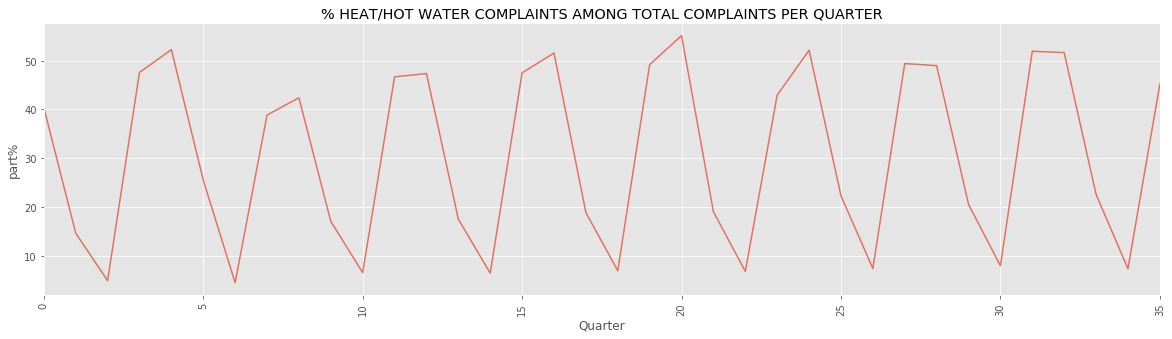

% HEAT/HOT WATER COMPLAINTS per quarter suggests seasonal behavior too


In [19]:
# 1.1.2. Visualizating Rate of HHW complaints per quarter:
# 1.1.2.1. Gross plotting:


ts_comp_q_00["part%"].plot(kind='line',alpha=0.75, rot=90, figsize=(20, 5))
plt.xlabel('Quarter') # , size=20)
plt.ylabel('part%') # , size=20)
plt.title("% HEAT/HOT WATER COMPLAINTS AMONG TOTAL COMPLAINTS PER QUARTER") # , size=10)
plt.show()

print("% HEAT/HOT WATER COMPLAINTS per quarter suggests seasonal behavior too")

In [20]:
# 1.1.2.2. % HHW Complaint frames:

# ts_comp_q1b=ts_comp_q_00[ts_comp_q_00["quarter"]==1]
ts_hhwPart_q1=ts_comp_q1b[["year","part%"]]
ts_hhwPart_q1.set_index("year",inplace=True)

# ts_comp_q2b=ts_comp_q_00[ts_comp_q_00["quarter"]==2]
ts_hhwPart_q2=ts_comp_q2b[["year","part%"]]
ts_hhwPart_q2.set_index("year",inplace=True)

# ts_comp_q3b=ts_comp_q_00[ts_comp_q_00["quarter"]==3]
ts_hhwPart_q3=ts_comp_q3b[["year","part%"]]
ts_hhwPart_q3.set_index("year",inplace=True)

# ts_comp_q4b=ts_comp_q_00[ts_comp_q_00["quarter"]==4]
ts_hhwPart_q4=ts_comp_q4b[["year","part%"]]
ts_hhwPart_q4.set_index("year",inplace=True)

ts_hhwPart_q1.round() #shape

,part%
year,
2010,40.0
2011,52.0
2012,42.0
2013,47.0
2014,52.0
2015,55.0
2016,52.0
2017,49.0
2018,52.0


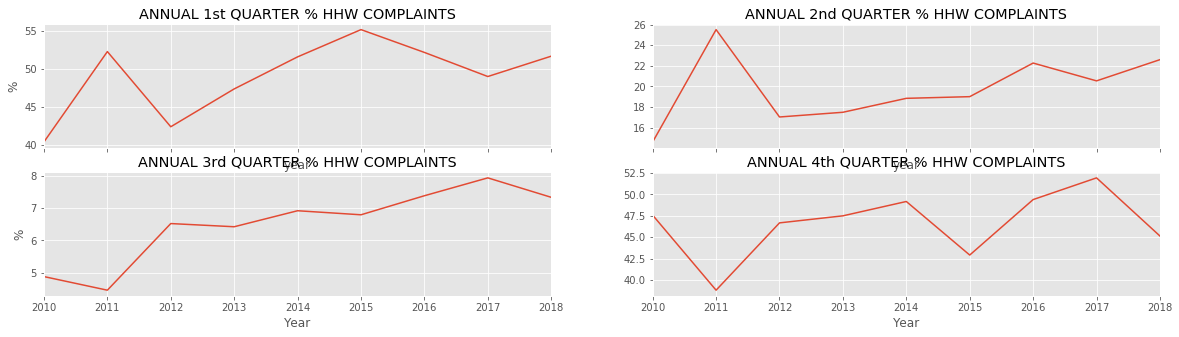

In [21]:
# 1.1.2.3. Seasonal Visualization

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
ts_hhwPart_q1["part%"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("ANNUAL 1st QUARTER % HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax0.set_ylabel("%")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
ts_hhwPart_q2["part%"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("ANNUAL 2nd QUARTER % HHW COMPLAINTS")
# ax1.set_xlabel("Year")
# ax1.set_ylabel("%")
ax1.set_xticklabels(())

# Subplot 1: Quarter III
ts_hhwPart_q3["part%"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("ANNUAL 3rd QUARTER % HHW COMPLAINTS")
ax2.set_xlabel("Year")
ax2.set_ylabel("%")

# Subplot 2: Quarter IV
ts_hhwPart_q4["part%"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("ANNUAL 4th QUARTER % HHW COMPLAINTS")
ax3.set_xlabel("Year")
# ax3.set_ylabel("%")


plt.show()

# % HHW complaints separated by quarters show more homogeneous behaviors, and consequently more predictable ones. Additionally, an 
# atypical behavior can be seen in 2010 and 2011 (regardless of the quarter assessed). Probably because these are the first years of
# the NYC311 service. Consequently, those years will not be considered for the 2019 predictions.")

# Note also that the % of complaints about HHW is markedly lower in Q2 (between 18% and 24%) and Q3 (between 6% and 8%) compared to Q1 
# and Q4 (between 40% and 55% in both quarters). Obviously, the climatic factor affects the amount of complaints by HHW, being these 
# greater in cold times. In other words, DHPNYC must prepare to address a greater number of complaints by HHW in autumn and winter")

In [23]:
# 1.1.2.4. Modeling total complaints per quarter:
# 1.1.2.4.1. Preprocessing

DF_Q1p=ts_comp_q1b[["year","part%"]]
DF_Q1p=DF_Q1p[DF_Q1p["year"]>2011]

DF_Q2p=ts_comp_q2b[["year","part%"]]
DF_Q2p=DF_Q2p[DF_Q2p["year"]>2011]

DF_Q3p=ts_comp_q3b[["year","part%"]]
DF_Q3p=DF_Q3p[DF_Q3p["year"]>2011]

DF_Q4p=ts_comp_q4b[["year","part%"]]
DF_Q4p=DF_Q4p[DF_Q4p["year"]>2011]


DF_Q1p.columns=["year","part%"]
DF_Q2p.columns=["year","part%"]
DF_Q3p.columns=["year","part%"]
DF_Q4p.columns=["year","part%"]

train1p=DF_Q1p[msk]
train2p=DF_Q2p[msk]
train3p=DF_Q3p[msk]
train4p=DF_Q4p[msk]

test1p=DF_Q1p[~msk]
test2p=DF_Q2p[~msk]
test3p=DF_Q3p[~msk]
test4p=DF_Q4p[~msk]

In [24]:
# 1.1.2.4.2. Modeling

# from sklearn import linear_model
regr1p=linear_model.LinearRegression()
regr2p=linear_model.LinearRegression()
regr3p=linear_model.LinearRegression()
regr4p=linear_model.LinearRegression()

# Quarter I:
X1p=np.asanyarray(train1p[["year"]])
y1p=np.asanyarray(train1p[["part%"]])
regr1p.fit(X1p,y1p)
yhat1p=regr1p.predict(test1p[["year"]])
X_test1p=np.asanyarray(test1p[["year"]])
y_test1p=np.asanyarray(test1p[["part%"]])

# Quarter II:
X2p=np.asanyarray(train2p[["year"]])
y2p=np.asanyarray(train2p[["part%"]])
regr2p.fit(X2p,y2p)
yhat2p=regr2p.predict(test2p[["year"]])
X_test2p=np.asanyarray(test2p[["year"]])
y_test2p=np.asanyarray(test2p[["part%"]])

# Quarter III:
X3p=np.asanyarray(train3p[["year"]])
y3p=np.asanyarray(train3p[["part%"]])
regr3p.fit(X3p,y3p)
yhat3p=regr3p.predict(test3p[["year"]])
X_test3p=np.asanyarray(test3p[["year"]])
y_test3p=np.asanyarray(test3p[["part%"]])

# Quarter IV:
X4p=np.asanyarray(train4p[["year"]])
y4p=np.asanyarray(train4p[["part%"]])
regr4p.fit(X4p,y4p)
yhat4p=regr4p.predict(test4p[["year"]])
X_test4p=np.asanyarray(test4p[["year"]])
y_test4p=np.asanyarray(test4p[["part%"]])

In [25]:
# 1.1.2.4.3. Predicting

yhat20191p=pd.DataFrame(regr1p.predict(x2019))
yhat20192p=pd.DataFrame(regr2p.predict(x2019))
yhat20193p=pd.DataFrame(regr3p.predict(x2019))
yhat20194p=pd.DataFrame(regr4p.predict(x2019))

hist1p=ts_comp_q1b[ts_comp_q1b["year"]>2011]
hist1p.reset_index(inplace=True,drop=True)

hist2p=ts_comp_q2b[ts_comp_q2b["year"]>2011]
hist2p.reset_index(inplace=True,drop=True)

hist3p=ts_comp_q3b[ts_comp_q3b["year"]>2011]
hist3p.reset_index(inplace=True,drop=True)

hist4p=ts_comp_q4b[ts_comp_q4b["year"]>2011]
hist4p.reset_index(inplace=True,drop=True)

pred2019p = pd.concat([df2019,hist1p["part%"],hist2p["part%"],hist3p["part%"],hist4p["part%"],
                       yhat20191p, yhat20192p, yhat20193p, yhat20194p], axis=1)
column=["year","Q1","Q2","Q3","Q4","estQ1","estQ2","estQ3","estQ4"]
pred2019p.columns=column

pred2019p.set_index("year",inplace=True)
pred2019p.round()

,Q1,Q2,Q3,Q4,estQ1,estQ2,estQ3,estQ4
year,,,,,,,,
2012.0,42.0,17.0,7.0,47.0,49.0,17.0,6.0,49.0
2013.0,47.0,17.0,6.0,47.0,49.0,18.0,7.0,49.0
2014.0,52.0,19.0,7.0,49.0,50.0,19.0,7.0,49.0
2015.0,55.0,19.0,7.0,43.0,50.0,20.0,7.0,49.0
2016.0,52.0,22.0,7.0,49.0,51.0,21.0,7.0,49.0
2017.0,49.0,21.0,8.0,52.0,51.0,22.0,8.0,49.0
2018.0,52.0,23.0,7.0,45.0,51.0,23.0,8.0,48.0
2019.0,NaN,NaN,NaN,NaN,52.0,24.0,8.0,48.0


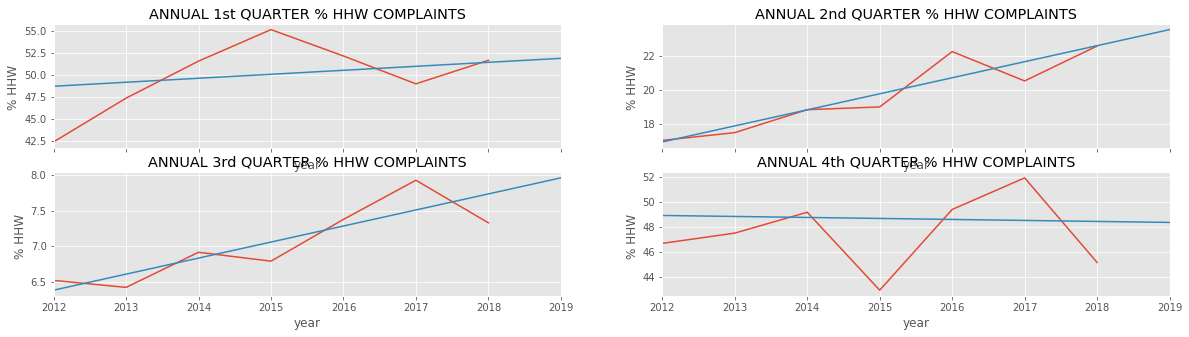

In [26]:
# 1.1.2.4.4. Plotting

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
pred2019p["Q1"].plot(kind="line",figsize=(20,5),ax=ax0)
pred2019p["estQ1"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("ANNUAL 1st QUARTER % HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax0.set_ylabel("% HHW ")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
pred2019p["Q2"].plot(kind="line",figsize=(20,5),ax=ax1)
pred2019p["estQ2"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("ANNUAL 2nd QUARTER % HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax1.set_ylabel("% HHW ")
ax1.set_xticklabels(())

# Subplot 3: Quarter III
pred2019p["Q3"].plot(kind="line",figsize=(20,5),ax=ax2)
pred2019p["estQ3"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("ANNUAL 3rd QUARTER % HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax2.set_ylabel("% HHW ")
# ax2.set_xticklabels(())

# Subplot 4: Quarter IV
pred2019p["Q4"].plot(kind="line",figsize=(20,5),ax=ax3)
pred2019p["estQ4"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("ANNUAL 4th QUARTER % HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax3.set_ylabel("% HHW ")
# ax3.set_xticklabels(())

plt.show()


In [27]:
# 1.1.2.4.5. Metrics

coeff=[regr1p.coef_[0][0],regr2p.coef_[0][0],regr3p.coef_[0][0],regr4p.coef_[0][0]]
intercept=[regr1p.intercept_[0],regr2p.intercept_[0],regr3p.intercept_[0],regr4p.intercept_[0]]
ResSumSqr=[np.mean((yhat1p-y_test1p)**2),np.mean((yhat2p-y_test2p)**2),np.mean((yhat3p-y_test3p)**2),np.mean((yhat4p-y_test4p)**2)]
VarScore=[regr1p.score(X_test1p,y_test1p),regr2p.score(X_test2p,y_test2p),regr3p.score(X_test3p,y_test3p),regr4p.score(X_test4p,y_test4p)]
R2Score=[r2_score(yhat1p,y_test1p),r2_score(yhat2p,y_test2p),r2_score(yhat3p,y_test3p),r2_score(yhat4p,y_test4p)]

Quarter=["Q1","Q2","Q3","Q4"]
ModPart={"Quarter":Quarter,"Intercept":intercept,"Coefficient":coeff,"Residuals":ResSumSqr,"Variance Score":VarScore,"R2":R2Score}
model_part2=pd.DataFrame(ModPart)
model_part2["hhwpred2019%"]=model_part2["Intercept"]+(2019*model_part2["Coefficient"])
model_part=pd.merge(model_part2,model_complaints[["Quarter","pred2019"]],left_on="Quarter",right_on="Quarter",how="inner")
model_part["hhwpred2019"]=model_part["hhwpred2019%"]*model_part["pred2019"]/100
#DF01=pd.merge(DFPLUTO,z02,left_on="Address",right_on="incident_address",how="left")

totcompl2019=model_part["pred2019"].sum()
tothhw2019=model_part["hhwpred2019"].sum()
estparthhw2019=100*(tothhw2019/totcompl2019)

print("Total complaints estimated part for 2019: %.0f"%totcompl2019," complaints")
print("Total hhw complaints estimated part for 2019: %.0f"%tothhw2019," hhw complaints")
print("Percentage of hhw complaints estimated for 2019: %.0f"%estparthhw2019,"%")

model_part.round()


Total complaints estimated part for 2019: 588750  complaints
Total hhw complaints estimated part for 2019: 223566  hhw complaints
Percentage of hhw complaints estimated for 2019: 38 %


,Quarter,Intercept,Coefficient,Residuals,Variance Score,R2,hhwpred2019%,pred2019,hhwpred2019
0,Q1,-861.0,0.0,33.0,0.0,-70.0,52.0,192774.0,99980.0
1,Q2,-1883.0,1.0,0.0,1.0,1.0,24.0,101526.0,23918.0
2,Q3,-448.0,0.0,0.0,-1.0,1.0,8.0,105725.0,8416.0
3,Q4,209.0,-0.0,19.0,-4.0,-1331.0,48.0,188724.0,91251.0


In [28]:
# 1.2. Rate of houses with HHW complaints per quarter:
# 1.2.0. Preprocessing (computing number of houses instead number of complaints):

ts_houses_q_01=df_compl02.groupby([df_compl02["incident_address"],
                                   df_compl02["created_date"].dt.year.rename("year"),df_compl02["created_date"].dt.quarter.rename("quarter")]).sum()
ts_houses_q_01["hhwbool"]=(ts_houses_q_01["hhw"]>0)
ts_houses_q_01["hhw2018bool"]=(ts_houses_q_01["hhw2018"]>0)
ts_houses_q_01.index=map(str,ts_houses_q_01.index)
ts_houses_q_01.reset_index(inplace=True)
ts_houses_q_01.columns=["index2","unique_key","incident_zip","latitude","longitude","hhw","hhw2018","hhwbool","hhw2018bool"]
ts_houses_q_01["year"] = ts_houses_q_01["index2"].str[-8:-4].astype(np.int)
ts_houses_q_01["quarter"] = ts_houses_q_01["index2"].str[-2:-1].astype(np.int)
ts_houses_q_02=ts_houses_q_01[["index2"]].groupby([ts_houses_q_01["year"],ts_houses_q_01["quarter"]]).count()
ts_houses_q_02.index=map(str,ts_houses_q_02.index)
ts_houses_q_02.reset_index(inplace=True)
ts_houses_q_02.columns=["index2","compl_houses"]
ts_houses_q_02["year"] = ts_houses_q_02["index2"].str[-8:-4].astype(np.int)
ts_houses_q_02["quarter"] = ts_houses_q_02["index2"].str[-2:-1].astype(np.int)
ts_houses_q_03=ts_houses_q_01[["hhwbool"]].groupby([ts_houses_q_01["year"],ts_houses_q_01["quarter"]]).sum()
ts_houses_q_03.index=map(str,ts_houses_q_03.index)
ts_houses_q_03.reset_index(inplace=True)
ts_houses_q_03.columns=["index2","hhwhouses_tot"]
ts_houses_q_03["year"] = ts_houses_q_02["index2"].str[-8:-4].astype(np.int)
ts_houses_q_03["quarter"] = ts_houses_q_02["index2"].str[-2:-1].astype(np.int)
ts_houses_q_00=pd.merge(ts_houses_q_03,ts_houses_q_02,left_on="index2",right_on="index2",how="inner")
ts_houses_q_00=ts_houses_q_00[["index2","year_x","quarter_x","hhwhouses_tot","compl_houses"]]
ts_houses_q_00["part%"]=100*(ts_houses_q_00["hhwhouses_tot"]/ts_houses_q_00["compl_houses"])
ts_houses_q_00.columns=["index2","year","quarter","hhwhouses","complhouses","part%"]
ts_houses_q_00.head()


,index2,year,quarter,hhwhouses,complhouses,part%
0,"(2010, 1)",2010,1,20877.0,27146,76.906358
1,"(2010, 2)",2010,2,6757.0,17287,39.087175
2,"(2010, 3)",2010,3,2623.0,16434,15.960813
3,"(2010, 4)",2010,4,24892.0,29793,83.549827
4,"(2011, 1)",2011,1,19566.0,23526,83.167559


In [29]:
# 1.2.1. Exploratory Analysis:

ts_houses_q_00[["hhwhouses","complhouses","part%"]].describe(include="all")

# Notice that the "number of houses with hhw complaints rate" has a mean of 53.6%, with a standard of 25.7%.
# Since a very very general perspective, it can be understood as, the probability than a house with complaints 
# in NYC use the NYC311 service for "hhw" complaints is in average 0.536. However, it is possible to go deeper in
# this analysis, so next, I´m going to check if there is any trend and modeling it.

,hhwhouses,complhouses,part%
count,36.000000,36.000000,36.000000
mean,13027.805556,21867.333333,53.629715
std,8516.490078,5856.272720,25.740008
min,2623.000000,12400.000000,15.960813
25%,5439.250000,16926.000000,34.079539
50%,12704.500000,20726.500000,60.063706
75%,20885.750000,27171.750000,77.322756
max,26003.000000,32709.000000,83.549827


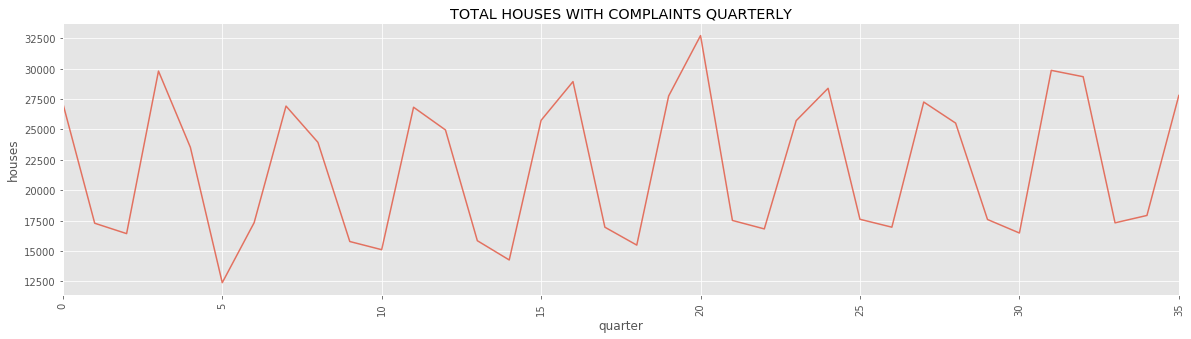

Total houses with complaints per quarter suggests seasonal behavior


In [30]:
# 1.2.2. Gross Visualization 

ts_houses_q_00["complhouses"].plot(kind='line',alpha=0.75, rot=90, figsize=(20, 5))
plt.xlabel('quarter') # , size=20)
plt.ylabel('houses') # , size=20)
plt.title("TOTAL HOUSES WITH COMPLAINTS QUARTERLY") # , size=10)
plt.show()
print("Total houses with complaints per quarter suggests seasonal behavior")


In [31]:
# 1.2.3. Seasonally adjusted series through quarterly analysis
# Summary of Total Houses with Complaints

ts_houses_q1b=ts_houses_q_00[ts_houses_q_00["quarter"]==1]
ts_houses_q1b.reset_index(inplace=True,drop=True)
ts_houses_q1=ts_houses_q1b[["year","complhouses"]]
ts_houses_q1.set_index("year",inplace=True)

ts_houses_q2b=ts_houses_q_00[ts_houses_q_00["quarter"]==2]
ts_houses_q2b.reset_index(inplace=True,drop=True)
ts_houses_q2=ts_houses_q2b[["year","complhouses"]]
ts_houses_q2.set_index("year",inplace=True)

ts_houses_q3b=ts_houses_q_00[ts_houses_q_00["quarter"]==3]
ts_houses_q3b.reset_index(inplace=True,drop=True)
ts_houses_q3=ts_houses_q3b[["year","complhouses"]]
ts_houses_q3.set_index("year",inplace=True)

ts_houses_q4b=ts_houses_q_00[ts_houses_q_00["quarter"]==4]
ts_houses_q4b.reset_index(inplace=True,drop=True)
ts_houses_q4=ts_houses_q4b[["year","complhouses"]]
ts_houses_q4.set_index("year",inplace=True)

ts_houses_q4.shape

(9, 1)

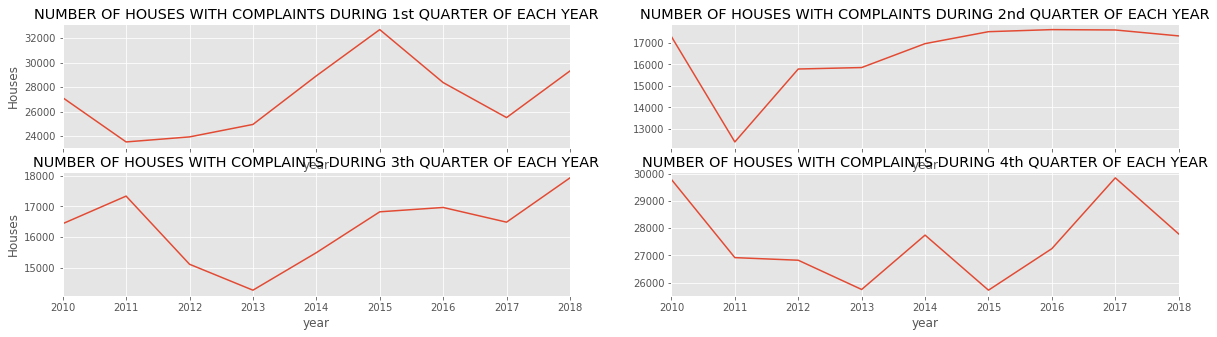

In [32]:
# 1.2.4. Total Houses Visualization

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
ts_houses_q1['complhouses'].plot(kind='line',figsize=(20,5),ax=ax0)
ax0.set_title('NUMBER OF HOUSES WITH COMPLAINTS DURING 1st QUARTER OF EACH YEAR')
# ax0.set_xlabel('year')
ax0.set_ylabel('Houses')
ax0.set_xticklabels(())

# Subplot 2: Quarter II
ts_houses_q2['complhouses'].plot(kind='line',figsize=(20,5),ax=ax1)
ax1.set_title('NUMBER OF HOUSES WITH COMPLAINTS DURING 2nd QUARTER OF EACH YEAR')
# ax1.set_xlabel('year')
# ax1.set_ylabel('Houses')
ax1.set_xticklabels(())

# Subplot 1: Quarter III
ts_houses_q3['complhouses'].plot(kind='line',figsize=(20,5),ax=ax2)
ax2.set_title('NUMBER OF HOUSES WITH COMPLAINTS DURING 3th QUARTER OF EACH YEAR')
ax2.set_xlabel('year')
ax2.set_ylabel('Houses')

# Subplot 2: Quarter IV
ts_houses_q4['complhouses'].plot(kind='line',figsize=(20,5),ax=ax3)
ax3.set_title('NUMBER OF HOUSES WITH COMPLAINTS DURING 4th QUARTER OF EACH YEAR')
ax3.set_xlabel('year')
# ax3.set_ylabel('Houses')

plt.show()

# Total houses with complaints separated by quarters show more homogeneous behaviors, and consequently more predictable ones. Additionally, an atypical
# behavior can be seen in 2010 and 2011 (regardless of the quarter assessed). Probably because these are the first years of the NYC311 service.
# Consequently, those years will not be considered for the 2019 predictions.

In [33]:
# 1.2.5. Modeling
# 1.2.5.1. Preprocessing

DF_Q1ht=ts_houses_q1b[["year","complhouses"]]
DF_Q1ht=DF_Q1ht[DF_Q1ht["year"]>2011]

DF_Q2ht=ts_houses_q2b[["year","complhouses"]]
DF_Q2ht=DF_Q2ht[DF_Q2ht["year"]>2011]

DF_Q3ht=ts_houses_q3b[["year","complhouses"]]
DF_Q3ht=DF_Q3ht[DF_Q3ht["year"]>2011]

DF_Q4ht=ts_houses_q4b[["year","complhouses"]]
DF_Q4ht=DF_Q4ht[DF_Q4ht["year"]>2011]


DF_Q1ht.columns=["year","complhouses"]
DF_Q2ht.columns=["year","complhouses"]
DF_Q3ht.columns=["year","complhouses"]
DF_Q4ht.columns=["year","complhouses"]

# mskh=np.random.rand(9)<.571

train1ht=DF_Q1ht[msk]
train2ht=DF_Q2ht[msk]
train3ht=DF_Q3ht[msk]
train4ht=DF_Q4ht[msk]

test1ht=DF_Q1ht[~msk]
test2ht=DF_Q2ht[~msk]
test3ht=DF_Q3ht[~msk]
test4ht=DF_Q4ht[~msk]

In [34]:
# 1.2.5.2. Developing model

from sklearn import linear_model
regr1ht=linear_model.LinearRegression()
regr2ht=linear_model.LinearRegression()
regr3ht=linear_model.LinearRegression()
regr4ht=linear_model.LinearRegression()

# Quarter I:
X1ht=np.asanyarray(train1ht[["year"]])
y1ht=np.asanyarray(train1ht[["complhouses"]])
regr1ht.fit(X1ht,y1ht)
yhat1ht=regr1ht.predict(test1ht[["year"]])
X_test1ht=np.asanyarray(test1ht[["year"]])
y_test1ht=np.asanyarray(test1ht[["complhouses"]])

# Quarter II:
X2ht=np.asanyarray(train2ht[["year"]])
y2ht=np.asanyarray(train2ht[["complhouses"]])
regr2ht.fit(X2ht,y2ht)
yhat2ht=regr2ht.predict(test2ht[["year"]])
X_test2ht=np.asanyarray(test2ht[["year"]])
y_test2ht=np.asanyarray(test2ht[["complhouses"]])

# Quarter III:
X3ht=np.asanyarray(train3ht[["year"]])
y3ht=np.asanyarray(train3ht[["complhouses"]])
regr3ht.fit(X3ht,y3ht)
yhat3ht=regr3ht.predict(test3ht[["year"]])
X_test3ht=np.asanyarray(test3ht[["year"]])
y_test3ht=np.asanyarray(test3ht[["complhouses"]])

# Quarter IV:
X4ht=np.asanyarray(train4ht[["year"]])
y4ht=np.asanyarray(train4ht[["complhouses"]])
regr4ht.fit(X4ht,y4ht)
yhat4ht=regr4ht.predict(test4ht[["year"]])
X_test4ht=np.asanyarray(test4ht[["year"]])
y_test4ht=np.asanyarray(test4ht[["complhouses"]])

In [35]:
# 1.2.5.3. Predicting

d_2019={"year":np.linspace(2012,2019,8)}
df2019=pd.DataFrame(d_2019)
x2019=np.asanyarray(df2019)

yhat20191ht=pd.DataFrame(regr1ht.predict(x2019))
yhat20192ht=pd.DataFrame(regr2ht.predict(x2019))
yhat20193ht=pd.DataFrame(regr3ht.predict(x2019))
yhat20194ht=pd.DataFrame(regr4ht.predict(x2019))

hist1ht=ts_houses_q1b[ts_houses_q1b["year"]>2011]
hist1ht.reset_index(inplace=True,drop=True)

hist2ht=ts_houses_q2b[ts_houses_q2b["year"]>2011]
hist2ht.reset_index(inplace=True,drop=True)

hist3ht=ts_houses_q3b[ts_houses_q3b["year"]>2011]
hist3ht.reset_index(inplace=True,drop=True)

hist4ht=ts_houses_q4b[ts_houses_q4b["year"]>2011]
hist4ht.reset_index(inplace=True,drop=True)

pred2019ht = pd.concat([df2019,hist1ht["complhouses"],hist2ht["complhouses"],hist3ht["complhouses"],hist4ht["complhouses"],
                       yhat20191ht, yhat20192ht, yhat20193ht, yhat20194ht], axis=1)
column=["year","Q1","Q2","Q3","Q4","estQ1","estQ2","estQ3","estQ4"]
pred2019ht.columns=column
pred2019ht.set_index("year",inplace=True)
pred2019ht. round()


,Q1,Q2,Q3,Q4,estQ1,estQ2,estQ3,estQ4
year,,,,,,,,
2012.0,23937.0,15784.0,15113.0,26822.0,26105.0,16044.0,13923.0,25991.0
2013.0,24956.0,15852.0,14268.0,25746.0,26471.0,16328.0,14563.0,26459.0
2014.0,28929.0,16961.0,15490.0,27746.0,26837.0,16613.0,15203.0,26927.0
2015.0,32709.0,17516.0,16821.0,25720.0,27203.0,16897.0,15842.0,27395.0
2016.0,28379.0,17612.0,16963.0,27249.0,27569.0,17182.0,16482.0,27864.0
2017.0,25517.0,17595.0,16484.0,29852.0,27935.0,17466.0,17122.0,28332.0
2018.0,29330.0,17320.0,17927.0,27789.0,28301.0,17751.0,17762.0,28800.0
2019.0,NaN,NaN,NaN,NaN,28667.0,18035.0,18402.0,29268.0


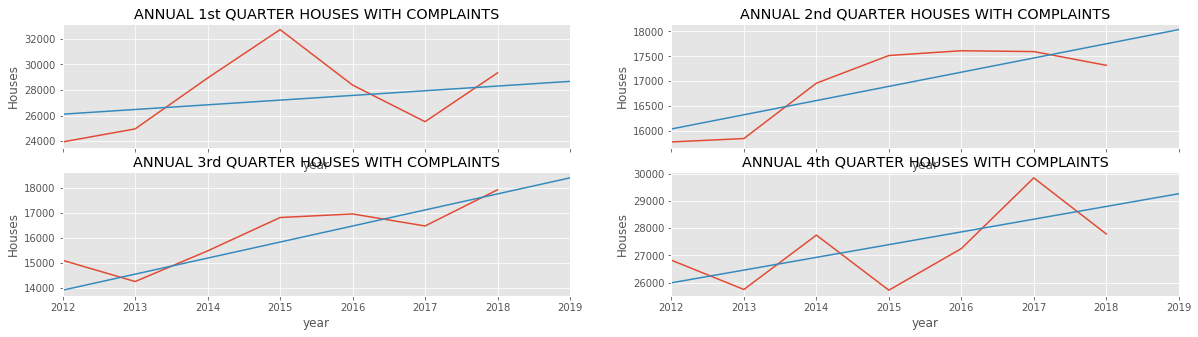

In [36]:
# 1.2.5.4. Plotting

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
pred2019ht["Q1"].plot(kind="line",figsize=(20,5),ax=ax0)
pred2019ht["estQ1"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("ANNUAL 1st QUARTER HOUSES WITH COMPLAINTS")
# ax0.set_xlabel("Year")
ax0.set_ylabel("Houses")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
pred2019ht["Q2"].plot(kind="line",figsize=(20,5),ax=ax1)
pred2019ht["estQ2"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("ANNUAL 2nd QUARTER HOUSES WITH COMPLAINTS")
# ax0.set_xlabel("Year")
ax1.set_ylabel("Houses")
ax1.set_xticklabels(())

# Subplot 3: Quarter III
pred2019ht["Q3"].plot(kind="line",figsize=(20,5),ax=ax2)
pred2019ht["estQ3"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("ANNUAL 3rd QUARTER HOUSES WITH COMPLAINTS")
# ax0.set_xlabel("Year")
ax2.set_ylabel("Houses")
# ax2.set_xticklabels(())

# Subplot 4: Quarter IV
pred2019ht["Q4"].plot(kind="line",figsize=(20,5),ax=ax3)
pred2019ht["estQ4"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("ANNUAL 4th QUARTER HOUSES WITH COMPLAINTS")
# ax0.set_xlabel("Year")
ax3.set_ylabel("Houses")
# ax3.set_xticklabels(())

plt.show()


In [37]:
# 1.2.5.5. Metrics

# from sklearn.metrics import r2_score

coeff=[regr1ht.coef_[0][0],regr2ht.coef_[0][0],regr3ht.coef_[0][0],regr4ht.coef_[0][0]]
intercept=[regr1ht.intercept_[0],regr2ht.intercept_[0],regr3ht.intercept_[0],regr4ht.intercept_[0]]
ResSumSqr=[np.mean((yhat1ht-y_test1ht)**2),np.mean((yhat2ht-y_test2ht)**2),np.mean((yhat3ht-y_test3ht)**2),np.mean((yhat4ht-y_test4ht)**2)]
VarScore=[regr1ht.score(X_test1ht,y_test1ht),regr2ht.score(X_test2ht,y_test2ht),regr3ht.score(X_test3ht,y_test3ht),regr4ht.score(X_test4ht,y_test4ht)]
R2Score=[r2_score(yhat1ht,y_test1ht),r2_score(yhat2ht,y_test2ht),r2_score(yhat3ht,y_test3ht),r2_score(yhat4ht,y_test4ht)]

Quarter=["Q1","Q2","Q3","Q4"]
ModHouses={"Quarter":Quarter,"Intercept":intercept,"Coefficient":coeff,"Residuals":ResSumSqr,"Variance Score":VarScore,"R2":R2Score}
model_houses=pd.DataFrame(ModHouses)
model_houses["pred2019"]=model_houses["Intercept"]+(2019*model_houses["Coefficient"])
totht2019=model_houses["pred2019"].sum()
print("Total estimated houses with complaints for 2019: %.0f"%totht2019," complaints")
model_houses

Total estimated houses with complaints for 2019: 94372  complaints


,Quarter,Intercept,Coefficient,Residuals,Variance Score,R2,pred2019
0,Q1,-7.103108e+05,366.011628,1.750941e+07,0.089805,-57.089723,28666.639535
1,Q2,-5.563233e+05,284.476744,2.251560e+05,0.699774,-0.236538,18035.220930
2,Q3,-1.273617e+06,639.930233,1.187253e+06,-0.627900,-0.288533,18402.162791
3,Q4,-9.159994e+05,468.186047,1.748969e+06,-4.760749,-2.546196,29268.232558


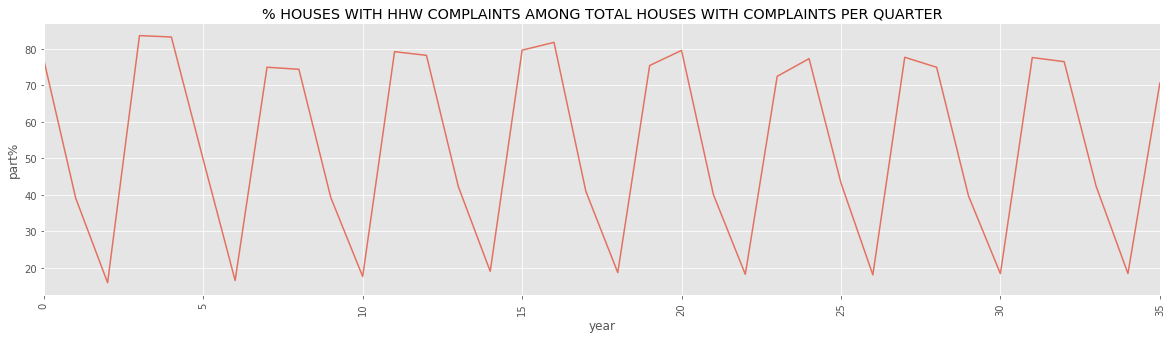

% Houses with HEAT/HOT WATER COMPLAINTS per quarter suggests seasonal behavior too


In [38]:
# 1.2.6. Visualizating Rate of houses with HHW complaints per year:
# 1.2.6.0. Gross visualization:

ts_houses_q_00["part%"].plot(kind='line',alpha=0.75, rot=90, figsize=(20, 5))
plt.xlabel('year') # , size=20)
plt.ylabel('part%') # , size=20)
plt.title("% HOUSES WITH HHW COMPLAINTS AMONG TOTAL HOUSES WITH COMPLAINTS PER QUARTER") # , size=10)
plt.show()

print("% Houses with HEAT/HOT WATER COMPLAINTS per quarter suggests seasonal behavior too")

In [39]:
# 1.2.6.1. frames:

# ts_houses_q1b=ts_houses_q_00[ts_houses_q_00["quarter"]==1]
ts_hhwPart_q1=ts_houses_q1b[["year","part%"]]
ts_hhwPart_q1.set_index("year",inplace=True)

# ts_houses_q2b=ts_houses_q_00[ts_houses_q_00["quarter"]==2]
ts_hhwPart_q2=ts_houses_q2b[["year","part%"]]
ts_hhwPart_q2.set_index("year",inplace=True)

# ts_houses_q3b=ts_houses_q_00[ts_houses_q_00["quarter"]==3]
ts_hhwPart_q3=ts_houses_q3b[["year","part%"]]
ts_hhwPart_q3.set_index("year",inplace=True)

# ts_houses_q4b=ts_houses_q_00[ts_houses_q_00["quarter"]==4]
ts_hhwPart_q4=ts_houses_q4b[["year","part%"]]
ts_hhwPart_q4.set_index("year",inplace=True)

ts_hhwPart_q1.round() #shape


,part%
year,
2010,77.0
2011,83.0
2012,74.0
2013,78.0
2014,82.0
2015,79.0
2016,77.0
2017,75.0
2018,76.0


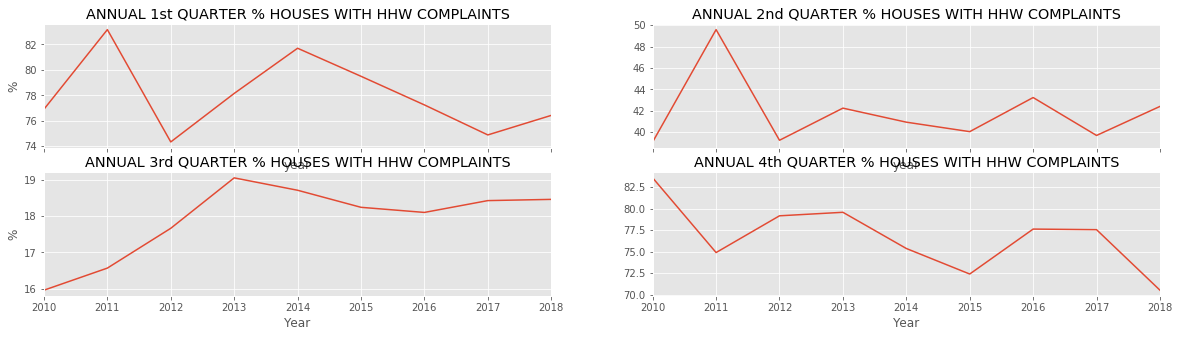

In [40]:
# 1.2.6.2. Seasonal Visualization

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
ts_hhwPart_q1["part%"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("ANNUAL 1st QUARTER % HOUSES WITH HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax0.set_ylabel("%")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
ts_hhwPart_q2["part%"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("ANNUAL 2nd QUARTER % HOUSES WITH HHW COMPLAINTS")
# ax1.set_xlabel("Year")
# ax1.set_ylabel("%")
ax1.set_xticklabels(())

# Subplot 1: Quarter III
ts_hhwPart_q3["part%"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("ANNUAL 3rd QUARTER % HOUSES WITH HHW COMPLAINTS")
ax2.set_xlabel("Year")
ax2.set_ylabel("%")

# Subplot 2: Quarter IV
ts_hhwPart_q4["part%"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("ANNUAL 4th QUARTER % HOUSES WITH HHW COMPLAINTS")
ax3.set_xlabel("Year")
# ax3.set_ylabel("%")


plt.show()

# % Houses with HHW complaints separated by quarters show more homogeneous behaviors, and consequently more predictable ones. Additionally, an 
# atypical behavior can be seen in 2010 and 2011 (regardless of the quarter assessed). Probably because these are the first years of
# the NYC311 service. Consequently, those years will not be considered for the 2019 predictions.")

# Note also that the % of houses with complaints about HHW is markedly lower in Q2 (between 16% and 22%) and Q3 (between 6% and 8%) compared to Q1 
# and Q4 (between 40% and 55% in both quarters). Obviously, the climatic factor affects the amount of houses with complaints by HHW, being these 
# greater in cold times. In other words, DHPNYC must prepare to address a greater number of complaints by HHW in autumn and winter")

In [41]:
# 1.2.6.3. Modeling % houses with hhw complaints per quarter:
# 1.2.6.3.0. Preprocessing

DF_Q1hp=ts_houses_q1b[["year","part%"]]
DF_Q1hp=DF_Q1hp[DF_Q1hp["year"]>2011]

DF_Q2hp=ts_houses_q2b[["year","part%"]]
DF_Q2hp=DF_Q2hp[DF_Q2hp["year"]>2011]

DF_Q3hp=ts_houses_q3b[["year","part%"]]
DF_Q3hp=DF_Q3hp[DF_Q3hp["year"]>2011]

DF_Q4hp=ts_houses_q4b[["year","part%"]]
DF_Q4hp=DF_Q4hp[DF_Q4hp["year"]>2011]


DF_Q1hp.columns=["year","part%"]
DF_Q2hp.columns=["year","part%"]
DF_Q3hp.columns=["year","part%"]
DF_Q4hp.columns=["year","part%"]

train1hp=DF_Q1hp[msk]
train2hp=DF_Q2hp[msk]
train3hp=DF_Q3hp[msk]
train4hp=DF_Q4hp[msk]

test1hp=DF_Q1hp[~msk]
test2hp=DF_Q2hp[~msk]
test3hp=DF_Q3hp[~msk]
test4hp=DF_Q4hp[~msk]

In [42]:
# 1.2.6.3.1. Model developing

# from sklearn import linear_model
regr1hp=linear_model.LinearRegression()
regr2hp=linear_model.LinearRegression()
regr3hp=linear_model.LinearRegression()
regr4hp=linear_model.LinearRegression()

# Quarter I:
X1hp=np.asanyarray(train1hp[["year"]])
y1hp=np.asanyarray(train1hp[["part%"]])
regr1hp.fit(X1hp,y1hp)
yhat1hp=regr1hp.predict(test1hp[["year"]])
X_test1hp=np.asanyarray(test1hp[["year"]])
y_test1hp=np.asanyarray(test1hp[["part%"]])

# Quarter II:
X2hp=np.asanyarray(train2hp[["year"]])
y2hp=np.asanyarray(train2hp[["part%"]])
regr2hp.fit(X2hp,y2hp)
yhat2hp=regr2hp.predict(test2hp[["year"]])
X_test2hp=np.asanyarray(test2hp[["year"]])
y_test2hp=np.asanyarray(test2hp[["part%"]])

# Quarter III:
X3hp=np.asanyarray(train3hp[["year"]])
y3hp=np.asanyarray(train3hp[["part%"]])
regr3hp.fit(X3hp,y3hp)
yhat3hp=regr3hp.predict(test3hp[["year"]])
X_test3hp=np.asanyarray(test3hp[["year"]])
y_test3hp=np.asanyarray(test3hp[["part%"]])

# Quarter IV:
X4hp=np.asanyarray(train4hp[["year"]])
y4hp=np.asanyarray(train4hp[["part%"]])
regr4hp.fit(X4hp,y4hp)
yhat4hp=regr4hp.predict(test4hp[["year"]])
X_test4hp=np.asanyarray(test4hp[["year"]])
y_test4hp=np.asanyarray(test4hp[["part%"]])

In [43]:
# 1.2.6.3.2. Model predicting

yhat20191hp=pd.DataFrame(regr1hp.predict(x2019))
yhat20192hp=pd.DataFrame(regr2hp.predict(x2019))
yhat20193hp=pd.DataFrame(regr3hp.predict(x2019))
yhat20194hp=pd.DataFrame(regr4hp.predict(x2019))

hist1hp=ts_houses_q1b[ts_houses_q1b["year"]>2011]
hist1hp.reset_index(inplace=True,drop=True)

hist2hp=ts_houses_q2b[ts_houses_q2b["year"]>2011]
hist2hp.reset_index(inplace=True,drop=True)

hist3hp=ts_houses_q3b[ts_houses_q3b["year"]>2011]
hist3hp.reset_index(inplace=True,drop=True)

hist4hp=ts_houses_q4b[ts_houses_q4b["year"]>2011]
hist4hp.reset_index(inplace=True,drop=True)

pred2019hp = pd.concat([df2019,hist1hp["part%"],hist2hp["part%"],hist3hp["part%"],hist4hp["part%"],
                       yhat20191hp, yhat20192hp, yhat20193hp, yhat20194hp], axis=1)
column=["year","Q1","Q2","Q3","Q4","estQ1","estQ2","estQ3","estQ4"]
pred2019hp.columns=column

pred2019hp.set_index("year",inplace=True)
pred2019hp.round()

,Q1,Q2,Q3,Q4,estQ1,estQ2,estQ3,estQ4
year,,,,,,,,
2012.0,74.0,39.0,18.0,79.0,81.0,42.0,19.0,80.0
2013.0,78.0,42.0,19.0,80.0,80.0,42.0,19.0,79.0
2014.0,82.0,41.0,19.0,75.0,79.0,42.0,19.0,78.0
2015.0,79.0,40.0,18.0,72.0,78.0,42.0,19.0,77.0
2016.0,77.0,43.0,18.0,78.0,77.0,42.0,19.0,76.0
2017.0,75.0,40.0,18.0,78.0,76.0,42.0,18.0,75.0
2018.0,76.0,42.0,18.0,71.0,76.0,42.0,18.0,74.0
2019.0,NaN,NaN,NaN,NaN,75.0,42.0,18.0,72.0


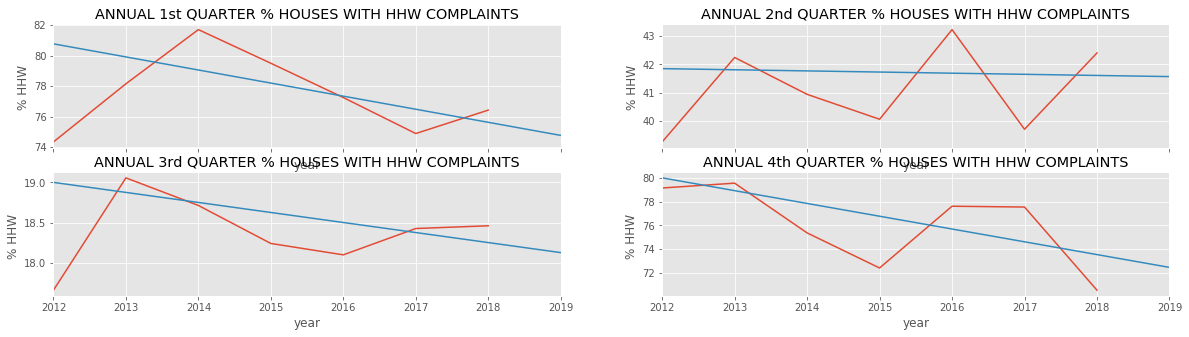

In [44]:
# 1.2.6.3.3. Model visualization

fig = plt.figure()
ax0=fig.add_subplot(221)
ax1=fig.add_subplot(222)
ax2=fig.add_subplot(223)
ax3=fig.add_subplot(224)

# Subplot 1: Quarter I
pred2019hp["Q1"].plot(kind="line",figsize=(20,5),ax=ax0)
pred2019hp["estQ1"].plot(kind="line",figsize=(20,5),ax=ax0)
ax0.set_title("ANNUAL 1st QUARTER % HOUSES WITH HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax0.set_ylabel("% HHW ")
ax0.set_xticklabels(())

# Subplot 2: Quarter II
pred2019hp["Q2"].plot(kind="line",figsize=(20,5),ax=ax1)
pred2019hp["estQ2"].plot(kind="line",figsize=(20,5),ax=ax1)
ax1.set_title("ANNUAL 2nd QUARTER % HOUSES WITH HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax1.set_ylabel("% HHW ")
ax1.set_xticklabels(())

# Subplot 3: Quarter III
pred2019hp["Q3"].plot(kind="line",figsize=(20,5),ax=ax2)
pred2019hp["estQ3"].plot(kind="line",figsize=(20,5),ax=ax2)
ax2.set_title("ANNUAL 3rd QUARTER % HOUSES WITH HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax2.set_ylabel("% HHW ")
# ax2.set_xticklabels(())

# Subplot 4: Quarter IV
pred2019hp["Q4"].plot(kind="line",figsize=(20,5),ax=ax3)
pred2019hp["estQ4"].plot(kind="line",figsize=(20,5),ax=ax3)
ax3.set_title("ANNUAL 4th QUARTER % HOUSES WITH HHW COMPLAINTS")
# ax0.set_xlabel("Year")
ax3.set_ylabel("% HHW ")
# ax3.set_xticklabels(())

plt.show()

In [45]:
# 1.2.6.3.4. Metrics

coeff=[regr1hp.coef_[0][0],regr2hp.coef_[0][0],regr3hp.coef_[0][0],regr4hp.coef_[0][0]]
intercept=[regr1hp.intercept_[0],regr2hp.intercept_[0],regr3hp.intercept_[0],regr4hp.intercept_[0]]
ResSumSqr=[np.mean((yhat1hp-y_test1hp)**2),np.mean((yhat2hp-y_test2hp)**2),np.mean((yhat3hp-y_test3hp)**2),np.mean((yhat4hp-y_test4hp)**2)]
VarScore=[regr1hp.score(X_test1hp,y_test1hp),regr2hp.score(X_test2hp,y_test2hp),regr3hp.score(X_test3hp,y_test3hp),regr4hp.score(X_test4hp,y_test4hp)]
R2Score=[r2_score(yhat1hp,y_test1hp),r2_score(yhat2hp,y_test2hp),r2_score(yhat3hp,y_test3hp),r2_score(yhat4hp,y_test4hp)]

Quarter=["Q1","Q2","Q3","Q4"]
ModPart={"Quarter":Quarter,"Intercept":intercept,"Coefficient":coeff,"Residuals":ResSumSqr,"Variance Score":VarScore,"R2":R2Score}
model_part2=pd.DataFrame(ModPart)
model_part2["hhwpred2019%"]=model_part2["Intercept"]+(2019*model_part2["Coefficient"])
model_part=pd.merge(model_part2,model_houses[["Quarter","pred2019"]],left_on="Quarter",right_on="Quarter",how="inner")
model_part["hhwpred2019"]=model_part["hhwpred2019%"]*model_part["pred2019"]/100

tothouses2019=model_part["pred2019"].sum()
tothouseshhw2019=model_part["hhwpred2019"].sum()
estparthouseshhw2019=100*(tothouseshhw2019/tothouses2019)

print("Estimated of houses with complaints for 2019: %.0f"%tothouses2019," houses")
print("Estimated of houses with hhw complaints for 2019: %.0f"%tothouseshhw2019," houses")
print("Estimated of percentage of houses with hhw complaints for 2019: %.0f"%estparthouseshhw2019,"%")

model_part.round()

Estimated of houses with complaints for 2019: 94372  houses
Estimated of houses with hhw complaints for 2019: 53474  houses
Estimated of percentage of houses with hhw complaints for 2019: 57 %


,Quarter,Intercept,Coefficient,Residuals,Variance Score,R2,hhwpred2019%,pred2019,hhwpred2019
0,Q1,1807.0,-1.0,22.0,-2.0,-12.0,75.0,28667.0,21433.0
1,Q2,123.0,-0.0,5.0,-29.0,-1309.0,42.0,18035.0,7497.0
2,Q3,269.0,-0.0,1.0,-11.0,-27.0,18.0,18402.0,3337.0
3,Q4,2249.0,-1.0,10.0,0.0,-3.0,72.0,29268.0,21208.0


In [46]:
# 2. ESTIMATE NUMBER OF HOUSES WITH FUTURE HHW COMPLAINTS USING CLASSIFICATION MODELS
# 2.0. Preprocessing Data:
# 2.0.1. Defining response vector:

y=DF01["hhw2018bool"].values
y[0:5]


array([False, False, False, False, False])

In [47]:
# 2.0.2. Defining independent variables array:

X=DF01[['BldgArea','BldgDepth','BuiltFAR','CommFAR','FacilFAR','LotArea','LotDepth','NumBldgs','NumFloors','OfficeArea',
'ResArea','ResidFAR','RetailArea','YearBuilt','YearAlter1','hhw2018']].values
X[0:2]
#len(X)

array([[163894.0, 195.0, 833.0, 2.0, 65.0, 19682.0, 20725.0, 1.0, 10.0,
        147505.0, 0.0, 54.0, 16389.0, 1920.0, 1994.0, 0.0],
       [9585.0, 113.0, 9.0, 2.0, 0.0, 10650.0, 21317.0, 1.0, 1.0, 0.0,
        0.0, 0.0, 0.0, 1988.0, 1988.0, 0.0]], dtype=object)

In [48]:
# 2.0.3. Standarizing X:

X=preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:2]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 2.56119193, -0.03161251, 10.11953803,  0.71298317,  4.48827768,
         0.04563308,  4.71178605, -0.11768772, -0.0456637 ,  6.75842172,
        -0.13362665,  0.19421552,  2.70346734, -0.71462161,  2.85923694,
        -0.0541821 ],
       [ 0.04781912, -0.10768139, -0.77397036,  0.71298317, -0.45711263,
         0.01417739,  4.85693989, -0.11768772, -0.27268699, -0.03647672,
        -0.13362665, -0.53689197, -0.05645875,  1.60415952,  2.84958405,
        -0.0541821 ]])

In [49]:
# 2.0.4. Train / Test split:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
print("train_set: ",X_train.shape,y_train.shape)
print("test_set: ",X_test.shape,y_test.shape)


train_set:  (651000, 16) (651000,)
test_set:  (162751, 16) (162751,)


In [50]:
# 2.2. Modeling with Logistic Regression
# 2.2.1. Import library

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [51]:
# 2.2.2. Training:

LR=LogisticRegression(solver="liblinear").fit(X_train,y_train) 
# different solvers were tried, optimal solver is "liblinear" #c=0.01,

# 2.2.3. Predicting:

yhat_lr=LR.predict(X_test)
# yhat[0:5]

# 2.2.4. Accuracy Evaluation:
from sklearn import metrics
print("train set accuracy: ",metrics.accuracy_score(y_train,LR.predict(X_train)))
print("test set accuracy: ",metrics.accuracy_score(y_test,yhat_lr))

print("LR model can predict with a ",metrics.accuracy_score(y_test,yhat_lr),
      " of accuracy, if NYC houses will register 'HEAT/HOT WATER' issues in the future")


train set accuracy:  1.0
test set accuracy:  1.0
LR model can predict with a  1.0  of accuracy, if NYC houses will register 'HEAT/HOT WATER' issues in the future


In [52]:
yhat_lr_prob=LR.predict_proba(X_test)
yhat_lr_prob[0:5]


array([[0.00000000e+00, 1.00000000e+00],
       [9.99795118e-01, 2.04881968e-04],
       [9.99801490e-01, 1.98510011e-04],
       [9.99754951e-01, 2.45048986e-04],
       [9.99820326e-01, 1.79673847e-04]])

In [53]:
# 2.2.5. log loss (log loss close to "0" suggest "yhat" is closer than "y"):
from sklearn.metrics import log_loss

log_loss(y_test,yhat_lr)


9.99200722162641e-16

In [54]:
# 2.3. Modeling with SVM
# 2.3.1. Import library

from sklearn import svm

In [55]:
# 2.3.2. Training:

clf=svm.SVC(kernel="linear").fit(X_train,y_train) 
# different kernels were tried, optimal kernel is "linear"

# 2.3.3. Predicting:

yhat_svm=clf.predict(X_test)
# yhat[0:5]

# 2.3.4. Accuracy Evaluation:

print("train set accuracy: ",metrics.accuracy_score(y_train,clf.predict(X_train)))
print("test set accuracy: ",metrics.accuracy_score(y_test,yhat_svm))

print("SVM model can predict with a ",metrics.accuracy_score(y_test,yhat_svm),
      " of accuracy, if NYC houses will register 'HEAT/HOT WATER' issues in the future")


train set accuracy:  1.0
test set accuracy:  1.0
SVM model can predict with a  1.0  of accuracy, if NYC houses will register 'HEAT/HOT WATER' issues in the future


In [56]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

f1_score(y_test,yhat_svm,average="weighted")
print(classification_report(y_test,yhat_svm))


              precision    recall  f1-score   support

       False       1.00      1.00      1.00    157732
        True       1.00      1.00      1.00      5019

   micro avg       1.00      1.00      1.00    162751
   macro avg       1.00      1.00      1.00    162751
weighted avg       1.00      1.00      1.00    162751



In [57]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,yhat_svm))


[[157732      0]
 [     0   5019]]


In [58]:
# CONCLUSION:

# Regarding to the question about if it is possible built a model for future prediction of the possibility of heat / hot 
# water complaints (hhw), the answer is Yes, it is possible. In fact, it is possible to build several models from 
# different approaches. 
# This notebook shows some of those possible approaches. Their main results were:

# 1. Lineal Modeling:
#    Lineal model were applied over historical complaints dataset (NYC311) to get a general idea of:
#      1.1. Possible number of hhw complaints in 2019: 226,962 hhw complaints, wich represent the 38% of the total complaints expected for 2019
#      1.2. The approximated probability of 2019 complaints be by hhw is .38
#      1.3. Possible number of houses with hhw complaints in 2019: 55,816 houses, wich represent the 59% of the total of houses with complaints expected for 2019
#      1.4. The approximated probability than houses with complaints be by hhw in 2019 is .59
#      1.5. Historical data shows a seasonal behavior of complaints. For this reason analysis were made by quarters, using lineal models.
#      1.6. Lineal models showed low levels of accuracy; however, they offer a general insight of complaint trends.
#      1.7. Polynomial and not linear regression models were deprecated because data set includes only 10 years, and the first couple showed an atypical behavior.
#      1.8. Notice that time series analysis use to be done with techniques like ARIMA (Auto Regressive Integrated Moving 
#           Average) or SARIMA (Seasonal Auto Regressive Integrated Moving Average) models, however it is out of the scope
#           of this notebook.

# 2. Multivariate classification approach:
#    Through the classification methods and the characteristics of the houses available in the PLUTO data, models identified the NYC houses are likely to register
#    HHW complaints.
#    Top performing models were "Log Regression" and "SVM" which reached 100% of accuracy. It means that with this models the DHPDNYC will be able to predict if a 
#    NYC house will register hhw complaints with an almost perfect level of accuracy.
#    KNN model were tried but it takes too many execution time to identify the optimal "k" and to perform with, so it was excluded. 
